In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#### TODO install geopandas
#import geopandas as gp
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.sparse import coo_matrix, csr_matrix

Read in standardized csv files and merge them into one Dataframe

In [2]:
df_form = pd.read_csv("formationout.csv")
df_well = pd.read_csv("out.csv")
#Merge the 2 CSVs by API number
df_merged = df_well.merge(df_form, how = "left", on = "API Number")
#drop well number identifier since we are using API number
df_merged.drop(columns="Well Number", inplace = True)
print(df_merged.head())

     API Number  Northing   Easting  True Vertical Depth  Normalized TVD  \
0  490251039700  974652.3  794810.9              -2007.0        0.451998   
1  490251039700  974652.3  794810.9              -2007.0        0.451998   
2  490251039700  974652.3  794810.9              -2007.0        0.451998   
3  490251039700  974652.3  794810.9              -2007.0        0.451998   
4  490251039700  974652.3  794810.9              -2007.0        0.451998   

   Form Alias   Top MD  
0        22.0  1564.04  
1        19.0   910.29  
2        10.0  2785.42  
3        20.0  1461.42  
4        23.0   527.25  


Taking a sample of the Dataframe to holdout 

In [25]:
df_holdout = df_merged.sample(frac=0.2, random_state=4242001)
#make list of API numbers that we held out
heldout_APIs = []
for i in df_holdout["API Number"]:
    heldout_APIs.append(i)
#now we need to go back to our original Dataframe and set the vals we are holding out to 0
print(df_holdout.head())
df_merged_heldout = df_merged.copy()
df_merged_heldout.iloc[2933, 6] = 0
df_merged_heldout.iloc[2439, 6] = 0
df_merged_heldout.iloc[3298, 6] = 0
df_merged_heldout.iloc[542, 6] = 0
df_merged_heldout.iloc[5466, 6] = 0

        API Number  Northing   Easting  True Vertical Depth  Normalized TVD  \
2933  490251070700  961733.9  802774.0              -4401.0        0.095110   
2439  490251059500  965073.6  794723.3              -2121.5        0.434928   
3298  490251078100  967006.2  796184.8              -1015.0        0.599881   
542   490250952100  974478.6  792059.1              -2268.0        0.413089   
5466  490251118100  973327.5  794161.2              -2076.6        0.441622   

      Form Alias   Top MD  
2933         2.0    54.74  
2439        18.0  2783.22  
3298         0.0   229.35  
542          9.0  2293.08  
5466         8.0  2369.47  


Make a sparse matrix from the Dataframe heldout

In [4]:
D_df = df_merged_heldout.pivot_table("Top MD","Form Alias","API Number").fillna(0)

Trying different ways of normalizing R, demeaning and normalizing with SKLearn

In [5]:
mms = MinMaxScaler()
R = D_df.values
target_vals = df_holdout["Top MD"]
well_depth_mean = np.mean(R, axis = 1)
R_normalize = mms.fit_transform(R, target_vals)
R_demeaned = R - well_depth_mean.reshape(-1, 1)

Create binarized matrix with values of 1 where there are depth values in the sparse matrix R and values of 0 where there are not depth values in the sparse matrix R.

In [6]:
from sklearn.preprocessing import binarize
A = binarize(R)

This is the code that runs Alternating Least Squares factorization

In [7]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    print("Initiating ")
    MAE = []
    for i in range(1, n_factors):
        lambda_ = lambda_
        n_factors = n_factors
        n, m = A.shape
        n_iterations = n_iterations
        Users = 5 * np.random.rand(n, n_factors)
        Items = 5 * np.random.rand(n_factors, m)

        def get_error(A, Users, Items, R):
            # This calculates the MSE of nonzero elements
            return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

        MSE_List = []

        print("Starting Iterations")
        for iter in range(n_iterations):
            for i, Ri in enumerate(R):
                Users[i] = np.linalg.solve(
                    np.dot(Items, np.dot(np.diag(Ri), Items.T))
                    + lambda_ * np.eye(n_factors),
                    np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
                    ).T
            print(
                "Error after solving for User Matrix:",
                get_error(A, Users, Items, R),
                )

            for j, Rj in enumerate(R.T):
                Items[:, j] = np.linalg.solve(
                    np.dot(Users.T, np.dot(np.diag(Rj), Users))
                    + lambda_ * np.eye(n_factors),
                    np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
                    )
            print(
                "Error after solving for Item Matrix:",
                 get_error(A, Users, Items, R),
                )

            MSE_List.append(get_error(A, Users, Items, R))
            print("%sth iteration is complete..." % iter)
        MAE.append(MSE_List)
    return Users, Items, MAE
    
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    # plt.show()

In [8]:
U, Vt, MAE_list = runALS(R_normalize, A, 20, 20, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 0.06063865165831086
Error after solving for Item Matrix: 0.3103725412508529
0th iteration is complete...
Error after solving for User Matrix: 0.003466974887131205
Error after solving for Item Matrix: 0.004463519834429189
1th iteration is complete...
Error after solving for User Matrix: 0.00017704462685286303
Error after solving for Item Matrix: 0.0020550574091096722
2th iteration is complete...
Error after solving for User Matrix: 0.0001016636176545198
Error after solving for Item Matrix: 0.0010763469906634473
3th iteration is complete...
Error after solving for User Matrix: 7.809455352509753e-05
Error after solving for Item Matrix: 0.0006898522578203418
4th iteration is complete...
Error after solving for User Matrix: 6.39926131326792e-05
Error after solving for Item Matrix: 0.0004957463471978241
5th iteration is complete...
Error after solving for User Matrix: 5.517299761672758e-05
Error after solving for Item Matri

Error after solving for User Matrix: 4.5389913408697245e-05
Error after solving for Item Matrix: 0.000138603424730471
15th iteration is complete...
Error after solving for User Matrix: 4.477831320044683e-05
Error after solving for Item Matrix: 0.00012861009708236082
16th iteration is complete...
Error after solving for User Matrix: 4.428019966480816e-05
Error after solving for Item Matrix: 0.00011956581299005273
17th iteration is complete...
Error after solving for User Matrix: 4.3808967856428206e-05
Error after solving for Item Matrix: 0.00011163720402103335
18th iteration is complete...
Error after solving for User Matrix: 4.335857640939217e-05
Error after solving for Item Matrix: 0.00010485093811757398
19th iteration is complete...
Starting Iterations
Error after solving for User Matrix: 0.060342840409026946
Error after solving for Item Matrix: 0.29967196772910126
0th iteration is complete...
Error after solving for User Matrix: 0.004329020739466684
Error after solving for Item Matr

Error after solving for User Matrix: 4.5631328328241525e-05
Error after solving for Item Matrix: 0.000157401275263393
11th iteration is complete...
Error after solving for User Matrix: 4.4040938332511855e-05
Error after solving for Item Matrix: 0.00014073597778202759
12th iteration is complete...
Error after solving for User Matrix: 4.2701635467441366e-05
Error after solving for Item Matrix: 0.00012743824313789408
13th iteration is complete...
Error after solving for User Matrix: 4.161696067444368e-05
Error after solving for Item Matrix: 0.00011673576010449611
14th iteration is complete...
Error after solving for User Matrix: 4.08326170923918e-05
Error after solving for Item Matrix: 0.00010803940844651393
15th iteration is complete...
Error after solving for User Matrix: 4.032521171307875e-05
Error after solving for Item Matrix: 0.00010085041452359199
16th iteration is complete...
Error after solving for User Matrix: 3.999888745051112e-05
Error after solving for Item Matrix: 9.48035329

Error after solving for User Matrix: 5.002941388663348e-05
Error after solving for Item Matrix: 0.0003330651003217378
7th iteration is complete...
Error after solving for User Matrix: 4.718237869020028e-05
Error after solving for Item Matrix: 0.00028022353200448866
8th iteration is complete...
Error after solving for User Matrix: 4.506698879932851e-05
Error after solving for Item Matrix: 0.00023941585300683637
9th iteration is complete...
Error after solving for User Matrix: 4.3371873243986475e-05
Error after solving for Item Matrix: 0.0002076804039772378
10th iteration is complete...
Error after solving for User Matrix: 4.208253039071406e-05
Error after solving for Item Matrix: 0.0001830064241195594
11th iteration is complete...
Error after solving for User Matrix: 4.113399947309436e-05
Error after solving for Item Matrix: 0.00016371918477094447
12th iteration is complete...
Error after solving for User Matrix: 4.04248861325677e-05
Error after solving for Item Matrix: 0.00014835787505

Error after solving for User Matrix: 0.00011052042239596635
Error after solving for Item Matrix: 0.0013291870346380812
3th iteration is complete...
Error after solving for User Matrix: 7.962271294749102e-05
Error after solving for Item Matrix: 0.000909869351698364
4th iteration is complete...
Error after solving for User Matrix: 6.658024262923107e-05
Error after solving for Item Matrix: 0.000674753201270961
5th iteration is complete...
Error after solving for User Matrix: 5.8007271371564064e-05
Error after solving for Item Matrix: 0.0005259603564315359
6th iteration is complete...
Error after solving for User Matrix: 5.2412416505748726e-05
Error after solving for Item Matrix: 0.0004296616001580034
7th iteration is complete...
Error after solving for User Matrix: 4.932875552945879e-05
Error after solving for Item Matrix: 0.00036015389327923844
8th iteration is complete...
Error after solving for User Matrix: 4.758762954718335e-05
Error after solving for Item Matrix: 0.000305504743312271

Error after solving for User Matrix: 3.8189251375269e-05
Error after solving for Item Matrix: 9.063366730460278e-05
19th iteration is complete...
Starting Iterations
Error after solving for User Matrix: 0.06052616231168015
Error after solving for Item Matrix: 0.30860504043037223
0th iteration is complete...
Error after solving for User Matrix: 0.004137919487493974
Error after solving for Item Matrix: 0.004543245323812668
1th iteration is complete...
Error after solving for User Matrix: 0.00017007959957949655
Error after solving for Item Matrix: 0.0017558217416589737
2th iteration is complete...
Error after solving for User Matrix: 0.00010895714670166281
Error after solving for Item Matrix: 0.0009047404060630363
3th iteration is complete...
Error after solving for User Matrix: 7.841275068307013e-05
Error after solving for Item Matrix: 0.0005949536179332438
4th iteration is complete...
Error after solving for User Matrix: 6.418140650098725e-05
Error after solving for Item Matrix: 0.00044

Error after solving for User Matrix: 4.044425823822413e-05
Error after solving for Item Matrix: 0.00013541964378799298
15th iteration is complete...
Error after solving for User Matrix: 3.978468618176282e-05
Error after solving for Item Matrix: 0.00012496470776269004
16th iteration is complete...
Error after solving for User Matrix: 3.945839516289421e-05
Error after solving for Item Matrix: 0.00011640071607830632
17th iteration is complete...
Error after solving for User Matrix: 3.9326410004491176e-05
Error after solving for Item Matrix: 0.00010920166255002735
18th iteration is complete...
Error after solving for User Matrix: 3.924928773792285e-05
Error after solving for Item Matrix: 0.00010305294765037537
19th iteration is complete...
Starting Iterations
Error after solving for User Matrix: 0.06139628208150357
Error after solving for Item Matrix: 0.31294392498493884
0th iteration is complete...
Error after solving for User Matrix: 0.003839818250184714
Error after solving for Item Matr

Below finds the index of the minimum of the maximum error after each set of iterations. This is the optimal value for the parameter n_factors.

In [9]:
MAE_max = []
#get a list of the max errors from each value of n_factor
for i in MAE_list:
    MAE_max.append(max(i))
#The index of the minimum max error is the optimal n_factor value
print(MAE_max.index(min(MAE_max)))

7


In [10]:
recommendations = np.dot(U, Vt)
recsys_df = pd.DataFrame(data = recommendations[0:, 0:], index = D_df.index,
                        columns = D_df.columns)
recsys_df.head()

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,0.877732,0.905782,0.826258,0.865505,0.880701,0.849335,0.172911,0.861991,0.887214,0.846176,...,0.100260,0.064810,0.050466,0.094412,0.253418,0.064321,0.875069,0.038912,0.082218,-0.280433
1.0,0.389782,0.516516,0.432610,0.537332,0.588967,0.490515,0.232019,0.544004,0.430534,0.471810,...,0.185737,0.147801,0.141780,0.034330,0.185143,0.148334,0.519608,0.000621,0.036341,-0.105237
2.0,0.326852,0.462372,0.378321,0.488498,0.543143,0.439112,0.234105,0.496045,0.370412,0.419083,...,0.195007,0.155399,0.150093,0.028859,0.175946,0.156145,0.468646,-0.004415,0.030651,-0.079779
3.0,1.001086,1.000899,0.922602,0.941102,0.949629,0.934223,0.133504,0.939863,1.001027,0.933157,...,0.118190,0.080069,0.065172,0.115922,0.303384,0.077947,0.941071,0.056267,0.115110,-0.388298
4.0,0.189330,0.163786,0.979934,0.979560,0.979345,0.979736,0.098458,0.979489,0.181163,0.979832,...,0.107032,0.093453,0.078344,0.147920,0.106435,0.091168,0.979732,0.068129,0.151709,0.156822


Plot the recommended depths for all formations for the first 5 wells vs the actual depths

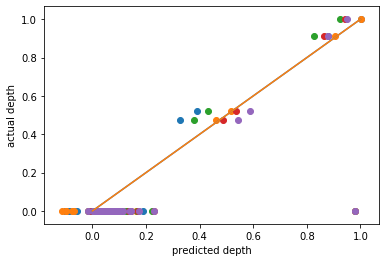

In [11]:
D_df_normalized = mms.fit_transform(D_df.iloc[0:, 1].values.reshape(-1,1))
for i in range(5):
    plt.scatter(recsys_df.iloc[0:, i].values, D_df_normalized) #plot predicted vs actual
    plt.xlabel('predicted depth')
    plt.ylabel('actual depth')
    plt.plot(np.arange(0,recsys_df.iloc[0:,i].max()))

Tough part, check predictions against known and use MAE error metric

In [12]:
#print(recsys_df)
recsys_df_toJoin = recsys_df.T.reset_index()
print(recsys_df_toJoin)

Form Alias    API Number       0.0       1.0       2.0       3.0       4.0  \
0           490250632500  0.877732  0.389782  0.326852  1.001086  0.189330   
1           490250632700  0.905782  0.516516  0.462372  1.000899  0.163786   
2           490250632800  0.826258  0.432610  0.378321  0.922602  0.979934   
3           490250632900  0.865505  0.537332  0.488498  0.941102  0.979560   
4           490250633200  0.880701  0.588967  0.543143  0.949629  0.979345   
5           490250633400  0.849335  0.490515  0.439112  0.934223  0.979736   
6           490250633800  0.172911  0.232019  0.234105  0.133504  0.098458   
7           490250633900  0.861991  0.544004  0.496045  0.939863  0.979489   
8           490250634000  0.887214  0.430534  0.370412  1.001027  0.181163   
9           490250634100  0.846176  0.471810  0.419083  0.933157  0.979832   
10          490250634300  0.859856  0.196081  0.117975  1.003372  0.235147   
11          490250634600  0.865770  0.327302  0.259910  1.001326

In [44]:
from sklearn.metrics import median_absolute_error
MAE = []
for i in range(0, int( df_merged.iloc[0:, 5].max() + 1 )):
    act_list = []
    pred_list = []
    #loop through all formation aliases
    #get actual df form alias i
    actual = df_merged[df_merged["Form Alias"] == float(i)]
    #get predicted df form alias i
    predicted = pd.DataFrame(recsys_df_toJoin[float(i)])
    #add API Number column to new dataframe
    predicted = predicted.assign(API=recsys_df_toJoin["API Number"])
    #query by API Number now
    actual = actual[actual["API Number"].isin(heldout_APIs)]
    predicted = predicted[predicted["API"].isin(heldout_APIs)]
    MAE.append( median_absolute_error( actual, mms.inverse_transform(predicted) ) )

ValueError: Found input variables with inconsistent numbers of samples: [583, 666]

Predicted depths

In [ ]:
recsys_df.iloc[0:, 1]

Actual depths

In [ ]:
D_df.iloc[0:, 1]

In [ ]:
plt.scatter(df_merged.Easting, df_merged.Northing, c = df_merged.iloc[0:, 6])
plt.colorbar()
plt.xlabel("Northing")
plt.ylabel("Easting")

